# Import thư viện cần thiết và setup cần thiết

In [1]:
import os
import sys
import time
import tarfile
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection, johnson_lindenstrauss_min_dim
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.utils import shuffle

class Config:
    RANDOM_STATE = 42
    FIG_SIZE = (20, 10)
    FONT_SCALE = 1.4
    
    PATH_MNIST = 'mnist_in_csv.gz'
    PATH_20NEWS = '20news-bydate.tar.gz'
    PATH_ECOMMERCE = 'ecommerce.gz'
    TEMP_DIR_20NEWS = "./temp_20news_ul"

    # Tham số thí nghiệm
    EPSILON = 0.1
    DELTA = 0.05
    SAMPLE_SIZE_EVAL = 5000
    SAMPLE_SIZE_ABLATION = 2000

    @staticmethod
    def setup_environment():
        warnings.filterwarnings("ignore")
        sns.set_theme(style="whitegrid", context="paper", font_scale=Config.FONT_SCALE)
        plt.rcParams['figure.figsize'] = Config.FIG_SIZE
        np.random.seed(Config.RANDOM_STATE)
        print("Environment Setup Completed.")

Config.setup_environment()

Environment Setup Completed.


# Setup dataset

In [2]:
def load_mnist(filepath=Config.PATH_MNIST):
    print(f"\n[Loader] Loading MNIST from {filepath}...")
    try:
        df = pd.read_csv(filepath, compression='gzip')
        X = df.iloc[:, 1:].values.astype(np.float32) / 255.0
        # Lấy nhãn (cột đầu tiên)
        y = df.iloc[:, 0].values.astype(np.int32)
        X = shuffle(X, random_state=Config.RANDOM_STATE)
        y = shuffle(y, random_state=Config.RANDOM_STATE)
        return X, y, "MNIST"
    except Exception as e: 
        print(f"Err MNIST: {e}")
        return None, None, None

def load_20news(filepath=Config.PATH_20NEWS):
    print(f"\n[Loader] Loading 20Newsgroups from {filepath}...")
    extract_path = Config.TEMP_DIR_20NEWS
    try:
        safe_extract_tar(filepath, extract_path)
        subdirs = [os.path.join(extract_path, d) for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
        target_dir = next((d for d in subdirs if 'train' in d), subdirs[0])
        data = load_files(target_dir, encoding='latin1')
        
        vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
        X = vectorizer.fit_transform(data.data)
        y = data.target # Lấy nhãn
        return X, y, "20Newsgroups"
    except Exception as e: 
        print(f"Err 20News: {e}")
        return None, None, None

def load_ecommerce(filepath=Config.PATH_ECOMMERCE):
    # Dataset này thường không có nhãn phân loại rõ ràng cho bài toán này, 
    # ta trả về dummy y hoặc bỏ qua trong bài test Accuracy
    print(f"\n[Loader] Loading Ecommerce from {filepath}...")
    try:
        df = pd.read_csv(filepath, compression='gzip', encoding='ISO-8859-1')
        df = df.dropna(subset=['Description'])
        vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
        X = vectorizer.fit_transform(df['Description'].astype(str))
        y = np.zeros(X.shape[0]) # Dummy label
        return X, y, "Ecommerce"
    except Exception as e: 
        print(f"Err Ecommerce: {e}")
        return None, None, None

def get_dataset_by_name(datasets, name):
    for X, y, n in datasets:
        if n == name: return X, y
    return None, None

# UTILITY FUNCTIONS

In [3]:
# --- CELL 2: UTILITY FUNCTIONS ---

def safe_extract_tar(filepath, extract_path):
    """Giải nén file tar an toàn."""
    if os.path.exists(extract_path): 
        shutil.rmtree(extract_path)
    try:
        with tarfile.open(filepath, "r:gz") as tar:
            if sys.version_info >= (3, 12): 
                tar.extractall(path=extract_path, filter='data')
            else: 
                tar.extractall(path=extract_path)
    except Exception as e:
        print(f"Error extracting {filepath}: {e}")

def collect_errors(X_orig, X_proj):
    if sparse.issparse(X_orig): 
        X_orig = X_orig.toarray()
    
    d_orig = euclidean_distances(X_orig)
    d_proj = euclidean_distances(X_proj)
    
    # Chỉ lấy phần tam giác trên để tránh tính trùng
    idx = np.triu_indices(d_orig.shape[0], k=1)
    dist_o = d_orig[idx]
    dist_p = d_proj[idx]
    
    # Tránh chia cho 0
    valid = dist_o > 1e-6
    if np.sum(valid) == 0: 
        return np.array([])
    
    return np.abs(dist_p[valid] / dist_o[valid] - 1.0)

def h_bennett(u):
    if u <= -1: return float('inf')
    return (1 + u) * np.log(1 + u) - u

def calculate_m_bennett(n, epsilon, delta, density):
    u = epsilon / density
    bennett_val = h_bennett(u)
    if bennett_val < 1e-12: 
        return johnson_lindenstrauss_min_dim(n, eps=epsilon)
    m = np.log(2/delta) / ((epsilon**2 / 2) * bennett_val)
    return int(np.ceil(m))

def estimate_ram(n_components, n_features, density, method="GRP"):
    if method == "GRP": 
        return (n_components * n_features * 8) / (1024**2)
    else: 
        # Sparse matrix storage estimation (CSR/CSC approximation)
        nnz = int(n_components * n_features * density)
        return (nnz * 12 + (n_components + 1) * 4) / (1024**2)

# Evaluation

In [4]:
def run_evaluation_suite(datasets):
    print("\n" + "="*50 + "\nPHASE 1: EVALUATION (Dynamic k)\n" + "="*50)
    stats = []
    scatter_data = {}
    
    # Unpack X, y, name (thêm y)
    for X, y, name in datasets:
        n, d = X.shape
        k_jl = johnson_lindenstrauss_min_dim(n, eps=Config.EPSILON)
        k = min(k_jl, d)
        
        print(f">>> Processing {name} (N={n}, d={d}) -> Calculated k={k}")
        
        actual_sample = min(Config.SAMPLE_SIZE_EVAL, n)
        idx = np.random.choice(n, actual_sample, replace=False)
        X_sample = X[idx]

        # 1. GRP
        t0 = time.time()
        grp = GaussianRandomProjection(n_components=k, random_state=Config.RANDOM_STATE)
        if d > 5000: 
            grp.fit(X[:200].toarray() if sparse.issparse(X) else X[:200]) 
            t_grp = (time.time() - t0) * (n/200)
        else:
            grp.fit(X)
            t_grp = time.time() - t0
        X_grp = grp.transform(X_sample.toarray() if sparse.issparse(X_sample) else X_sample)
        err_grp = collect_errors(X_sample, X_grp)
        mem_grp = estimate_ram(k, d, 1.0, "GRP")

        # 2. SRP
        t0 = time.time()
        srp = SparseRandomProjection(n_components=k, density='auto', random_state=Config.RANDOM_STATE)
        srp.fit(X)
        t_srp = time.time() - t0
        X_srp = srp.transform(X_sample)
        err_srp = collect_errors(X_sample, X_srp)
        
        actual_density = 1 / np.sqrt(d)
        
        stats.append({
            "Dataset": name, "Method": "GRP", "Time": t_grp, "Memory": mem_grp, 
            "Mean Error": np.mean(err_grp), "Max Error": np.max(err_grp)
        })
        stats.append({
            "Dataset": name, "Method": "SRP", "Time": t_srp, 
            "Memory": estimate_ram(k, d, actual_density, "SRP"), 
            "Mean Error": np.mean(err_srp), "Max Error": np.max(err_srp)
        })
        scatter_data[name] = {"GRP": err_grp, "SRP": err_srp, "k": k, "d": d, "N": n}

    return pd.DataFrame(stats), scatter_data

# Ablation 

In [5]:
def run_ablation_density_professional(datasets):
    print("\n>>> ABLATION 1: Density vs Bennett Theory (Scientific Verification)")
    X, y = get_dataset_by_name(datasets, "MNIST")
    if X is None: X, y = get_dataset_by_name(datasets, "20Newsgroups")
    
    if X is None: return pd.DataFrame()
    n_samples = 2000 
    epsilon = Config.EPSILON # 0.1

    if X.shape[0] > n_samples:
        X_sub = X[:n_samples]
    else:
        X_sub = X
        n_samples = X.shape[0]
        
    n_features = X_sub.shape[1]
    k_fixed = johnson_lindenstrauss_min_dim(n_samples, eps=epsilon)
    k_fixed = min(k_fixed, n_features) 
    
    print(f"  Setup: N={n_samples}, Fixed k={k_fixed}, Target epsilon={epsilon}")

    densities = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.3, 1.0]
    
    results = []

    for p in densities:
        m_required_theory = calculate_m_bennett(n_samples, epsilon, delta=0.05, density=p)
        srp = SparseRandomProjection(n_components=k_fixed, density=p, random_state=Config.RANDOM_STATE)
        
        try:
            srp.fit(X_sub)
            X_proj = srp.transform(X_sub)
            all_errors = collect_errors(X_sub, X_proj)
            
            if len(all_errors) == 0: continue
            max_error = np.max(all_errors)
            mean_error = np.mean(all_errors)
            failure_count = np.sum(all_errors > epsilon)
            failure_rate = failure_count / len(all_errors)
            
            results.append({
                "Density": p,
                "Used_k": k_fixed,
                "Theoretical_m_Required": m_required_theory,
                "Empirical_Max_Error": max_error,
                "Empirical_Failure_Rate": failure_rate,
                "Mean_Error": mean_error
            })
            print(f"    p={p:.3f}: Fail Rate={failure_rate:.4f}, Theo m={m_required_theory}")
            
        except Exception as e:
            print(f"    Skipping p={p}: {e}")

    return pd.DataFrame(results)
    
def run_ablation_convergence_deep(datasets):
    print("\n>>> ABLATION 2: Convergence Rate & Stability (Deep Analysis)")
    X, y, name = [(x, y, n) for x, y, n in datasets if n == "MNIST"][0]
    n_samples = 2000
    X_sample = X[:n_samples]
    n, d = X_sample.shape
    k_range = [50, 100, 200, 300, 400, 500, 600, 700, 784]
    results = []
    fixed_density = 1 / np.sqrt(d)
    print(f"  Fixed Density for SRP: {fixed_density:.4f} (Auto)")

    for k in k_range:
        # 1. GRP (Gaussian)
        grp = GaussianRandomProjection(n_components=k, random_state=Config.RANDOM_STATE)
        grp.fit(X_sample)
        X_grp = grp.transform(X_sample)
        err_grp = collect_errors(X_sample, X_grp)
        
        # 2. SRP (Sparse)
        srp = SparseRandomProjection(n_components=k, density=fixed_density, random_state=Config.RANDOM_STATE)
        srp.fit(X_sample)
        X_srp = srp.transform(X_sample)
        err_srp = collect_errors(X_sample, X_srp)
        
        # Lưu trữ thống kê chi tiết
        results.append({
            "k": k, "Method": "GRP", 
            "Mean_Error": np.mean(err_grp),
            "Std_Error": np.std(err_grp),
            "Max_Error": np.max(err_grp)
        })
        results.append({
            "k": k, "Method": "SRP", 
            "Mean_Error": np.mean(err_srp),
            "Std_Error": np.std(err_srp),
            "Max_Error": np.max(err_srp)
        })

    return pd.DataFrame(results)

def run_ablation_scalability_advanced(datasets):
    print("\n>>> ABLATION 3: Scalability & O(N) Verification (Advanced)")
    X, y, name = [(x, y, n) for x, y, n in datasets if n == "20Newsgroups"][0]
    n_total = X.shape[0]
    step = 1000
    n_range = list(range(1000, n_total + 1, step))
    if n_total not in n_range: n_range.append(n_total)
    
    results = []
    k = 300 
    print(f"  Dataset: {name}, Fixed k={k}, Testing N from {min(n_range)} to {max(n_range)}")

    for n_sub in n_range:
        X_sub = X[:n_sub]
        start = time.time()
        srp = SparseRandomProjection(n_components=k, density='auto', random_state=42)
        srp.fit(X_sub)
        res_srp = srp.transform(X_sub)
        time_srp = time.time() - start
        start = time.time()
        grp = GaussianRandomProjection(n_components=k, random_state=42)
        if n_sub > 2000:
            grp.fit(X_sub[:100].toarray()) 
            t_unit = (time.time() - start) / 100
            time_grp = t_unit * n_sub
        else:
            grp.fit(X_sub.toarray())
            grp.transform(X_sub.toarray())
            time_grp = time.time() - start

        speedup = time_grp / time_srp if time_srp > 0 else 0
        
        results.append({
            "N": n_sub,
            "Time_SRP": time_srp,
            "Time_GRP": time_grp,
            "Speedup": speedup
        })
        
    return pd.DataFrame(results)

# VISUALIZATION

In [6]:
def plot_evaluation_scatter(scatter_data):
    if not scatter_data: return
    for name, data in scatter_data.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
        viz_sample = min(2000, len(data["GRP"]))
        idx_g = np.random.choice(len(data["GRP"]), viz_sample, replace=False)
        idx_s = np.random.choice(len(data["SRP"]), viz_sample, replace=False)
        
        axes[0].scatter(np.arange(len(idx_g)), data["GRP"][idx_g], c='blue', alpha=0.4, s=15)
        axes[0].set_title(f"GRP on {name}", fontweight='bold', color='darkblue')
        axes[0].axhline(Config.EPSILON, c='green', ls='--', label=f'Target ε={Config.EPSILON}')
        
        axes[1].scatter(np.arange(len(idx_s)), data["SRP"][idx_s], c='red', alpha=0.4, s=15)
        axes[1].set_title(f"SRP on {name}", fontweight='bold', color='darkred')
        axes[1].axhline(Config.EPSILON, c='green', ls='--', label=f'Target ε={Config.EPSILON}')
        
        info = f"Dataset: {name}\nN={data['N']}, d={data['d']}\nCalculated k={data['k']}"
        fig.text(0.5, 0.92, info, ha='center', fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="gray"))
        plt.tight_layout(rect=[0, 0, 1, 0.88])
        plt.show()

def plot_resource_metrics(df_res):
    # (Giữ nguyên code cũ)
    if df_res.empty: return
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    sns.barplot(data=df_res, x="Dataset", y="Time", hue="Method", ax=axes[0,0], palette=["blue", "red"])
    axes[0,0].set_yscale('log'); axes[0,0].set_title("Time Efficiency (Log Scale)")
    sns.barplot(data=df_res, x="Dataset", y="Memory", hue="Method", ax=axes[0,1], palette=["blue", "red"])
    axes[0,1].set_yscale('log'); axes[0,1].set_title("Memory Footprint (Log Scale)")
    sns.barplot(data=df_res, x="Dataset", y="Mean Error", hue="Method", ax=axes[1,0], palette=["blue", "red"])
    axes[1,0].set_title("Mean Error"); axes[1,0].axhline(Config.EPSILON, c='k', ls='--')
    sns.barplot(data=df_res, x="Dataset", y="Max Error", hue="Method", ax=axes[1,1], palette=["blue", "red"])
    axes[1,1].set_title("Max Error"); axes[1,1].axhline(Config.EPSILON, c='k', ls='--')
    plt.tight_layout(); plt.show()

def plot_ablation_density_professional(df):
    if df.empty: return

    fig, axes = plt.subplots(1, 2, figsize=(22, 8))
    
    # --- PLOT 1: THEORETICAL GAP ANALYSIS ---
    # Mục tiêu: Chỉ ra sự chênh lệch giữa Lý thuyết Bennett (yêu cầu m khổng lồ) 
    # và Thực tế (ta chỉ dùng k nhỏ).
    
    # Vẽ vùng chênh lệch
    axes[0].fill_between(df["Density"], df["Theoretical_m_Required"], df["Used_k"], 
                         where=(df["Theoretical_m_Required"] > df["Used_k"]),
                         color='red', alpha=0.1, label='Efficiency Gap (Theory vs Reality)')
    
    # Đường Lý thuyết
    sns.lineplot(data=df, x="Density", y="Theoretical_m_Required", ax=axes[0], 
                 marker='o', color='gray', linestyle='--', label='Theoretical Required Dim ($m$)')
    
    # Đường Thực tế (k cố định)
    sns.lineplot(data=df, x="Density", y="Used_k", ax=axes[0], 
                 marker='s', color='blue', linewidth=3, label='Actual Used Dim ($k$)')
    
    axes[0].set_xscale('log')
    axes[0].set_yscale('log') # Log scale để nhìn rõ sự chênh lệch khủng khiếp
    axes[0].set_title("The Efficiency Gap: Theory vs. Practice", fontsize=16, fontweight='bold')
    axes[0].set_ylabel("Dimension ($k$ or $m$)", fontsize=14)
    axes[0].set_xlabel("Density ($p$) - Log Scale", fontsize=14)
    axes[0].legend()
    axes[0].grid(True, which="both", ls="-", alpha=0.2)
    
    # --- PLOT 2: EMPIRICAL FAILURE PROBABILITY ---
    # Mục tiêu: Khi nào thì ma trận thực sự "gãy"? (Failure Rate tăng vọt)
    
    # Đường Tỷ lệ lỗi thực tế (Empirical Failure Rate)
    sns.lineplot(data=df, x="Density", y="Empirical_Failure_Rate", ax=axes[1],
                 marker='D', color='crimson', linewidth=2, label='Empirical Failure Rate ($P(err > \epsilon)$)')
    
    # Đường Max Error (trục phụ) để đối chiếu
    ax2 = axes[1].twinx()
    sns.lineplot(data=df, x="Density", y="Empirical_Max_Error", ax=ax2,
                 marker='x', color='navy', linestyle=':', label='Worst-Case Distortion')
    
    # Ngưỡng Epsilon
    ax2.axhline(Config.EPSILON, color='green', linestyle='-', linewidth=2, label=f'Tolerance $\epsilon$={Config.EPSILON}')
    
    axes[1].set_xscale('log')
    axes[1].set_title("Phase Transition: When does Sparsity Break?", fontsize=16, fontweight='bold')
    axes[1].set_ylabel("Failure Probability (Fraction of Pairs > $\epsilon$)", fontsize=14, color='crimson')
    ax2.set_ylabel("Max Distortion Value", fontsize=14, color='navy')
    axes[1].set_xlabel("Density ($p$) - Log Scale", fontsize=14)
    
    # Combine legends
    lines1, labels1 = axes[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    axes[1].grid(True, which="both", ls="-", alpha=0.2)

    plt.tight_layout()
    plt.show()

def plot_ablation_convergence_deep(df):
    if df.empty: return

    fig, axes = plt.subplots(1, 2, figsize=(22, 8))
    
    # BIỂU ĐỒ 1: Mean Error + Confidence Interval (Stability)
    # Mục tiêu: Xem sai số trung bình giảm thế nào và độ ổn định (vùng mờ)
    methods = ["GRP", "SRP"]
    colors = {"GRP": "blue", "SRP": "red"}
    
    for m in methods:
        subset = df[df["Method"] == m]
        axes[0].plot(subset["k"], subset["Mean_Error"], marker='o', label=f'{m} Mean Error', color=colors[m])
        # Vẽ vùng lệch chuẩn (Mean +/- Std)
        axes[0].fill_between(subset["k"], 
                             subset["Mean_Error"] - subset["Std_Error"], 
                             subset["Mean_Error"] + subset["Std_Error"], 
                             color=colors[m], alpha=0.15, label=f'{m} Std Dev Range')
        
    # Vẽ đường Lý thuyết 1/sqrt(k) để so sánh
    k_vals = df[df["Method"]=="GRP"]["k"].values
    ref_val = df[df["Method"]=="GRP"]["Mean_Error"].values[0]
    # Mô hình lý thuyết: Error ~ 1/sqrt(k)
    theoretical_curve = ref_val * np.sqrt(k_vals[0]) / np.sqrt(k_vals)
    
    axes[0].plot(k_vals, theoretical_curve, 'k--', linewidth=2, label=r'Theoretical Decay ($O(1/\sqrt{k}$))')
    
    axes[0].set_title("Error Decay & Stability Analysis", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Projection Dimension ($k$)", fontsize=14)
    axes[0].set_ylabel("Mean Relative Error ($\pm$ Std Dev)", fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # BIỂU ĐỒ 2: Max Error vs k (Worst Case)
    # Mục tiêu: Đảm bảo không có điểm nào bị lỗi quá lớn
    sns.lineplot(data=df, x="k", y="Max_Error", hue="Method", style="Method", 
                 markers=True, dashes=False, palette=colors, ax=axes[1], linewidth=2.5)
    
    axes[1].axhline(Config.EPSILON, color='green', linestyle='--', label=f'Tolerance $\epsilon={Config.EPSILON}$')
    axes[1].set_title("Worst-Case Scenario Convergence", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Projection Dimension ($k$)", fontsize=14)
    axes[1].set_ylabel("Maximum Distortion", fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_ablation_scalability_advanced(df):
    if df.empty: return

    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # BIỂU ĐỒ 1: Linear Scale (Thực tế đau lòng)
    # Cho thấy sự chênh lệch khổng lồ về thời gian tuyệt đối
    axes[0].plot(df["N"], df["Time_GRP"], 'o--', color='blue', label='Gaussian RP (Dense)')
    axes[0].plot(df["N"], df["Time_SRP"], 's-', color='red', linewidth=2, label='Sparse RP')
    axes[0].set_title("1. Execution Time (Linear Scale)", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Sample Size ($N$)", fontsize=12)
    axes[0].set_ylabel("Time (seconds)", fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # BIỂU ĐỒ 2: Log-Log Scale (Chứng minh O(N)) -> CỰC KỲ QUAN TRỌNG
    # Trong biểu đồ Log-Log, đường thẳng có hệ số góc = 1 nghĩa là tuyến tính O(N)
    axes[1].loglog(df["N"], df["Time_GRP"], 'o--', color='blue', label='Gaussian RP')
    axes[1].loglog(df["N"], df["Time_SRP"], 's-', color='red', linewidth=2, label='Sparse RP')
    ref_x = df["N"]
    ref_y = df["Time_SRP"].iloc[0] * (ref_x / ref_x.iloc[0]) # y = c * x
    axes[1].loglog(ref_x, ref_y, 'k:', label=r'Theoretical $O(N)$')
    
    axes[1].set_title("2. Complexity Verification (Log-Log Scale)", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Sample Size ($N$) - Log Scale", fontsize=12)
    axes[1].set_ylabel("Time (s) - Log Scale", fontsize=12)
    axes[1].legend()
    axes[1].grid(True, which="both", alpha=0.3)
    
    # BIỂU ĐỒ 3: Speedup Factor (Hiệu quả thực tế)
    sns.barplot(data=df, x="N", y="Speedup", color='purple', ax=axes[2], alpha=0.7)
    axes[2].set_title("3. Speedup Factor (GRP Time / SRP Time)", fontsize=14, fontweight='bold')
    axes[2].set_xlabel("Sample Size ($N$)", fontsize=12)
    axes[2].set_ylabel("Times Faster (x)", fontsize=12)
    # Thêm text label giá trị lên cột
    for container in axes[2].containers:
        axes[2].bar_label(container, fmt='%.1fx', padding=3)
    
    plt.tight_layout()
    plt.show()

# Main

Loading Datasets...

[Loader] Loading MNIST from mnist_in_csv.gz...

[Loader] Loading 20Newsgroups from 20news-bydate.tar.gz...

[Loader] Loading Ecommerce from ecommerce.gz...
Running Main Evaluation...

PHASE 1: EVALUATION (Dynamic k)
>>> Processing MNIST (N=60000, d=784) -> Calculated k=784
>>> Processing 20Newsgroups (N=11314, d=56126) -> Calculated k=8000
>>> Processing Ecommerce (N=540455, d=2200) -> Calculated k=2200


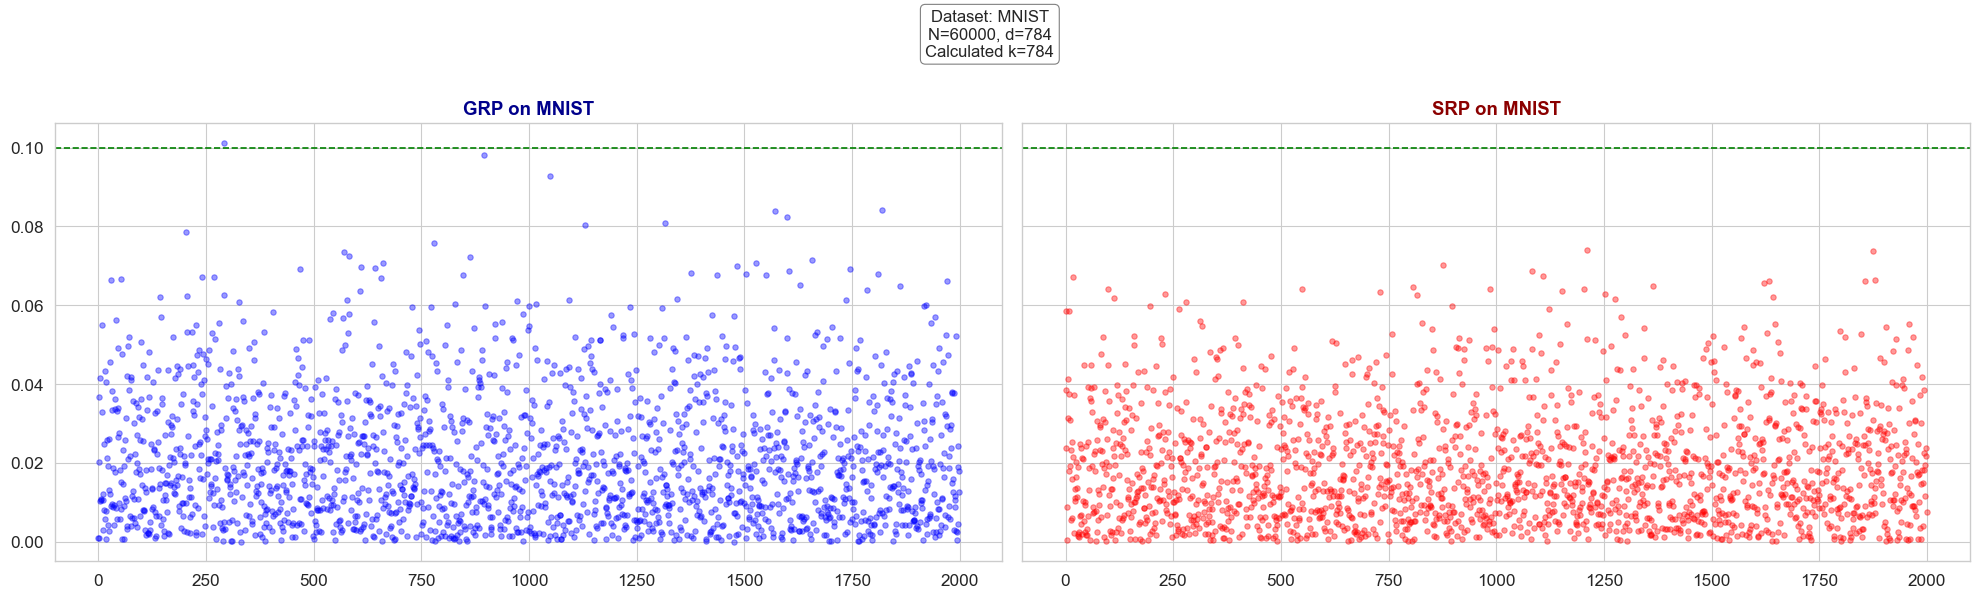

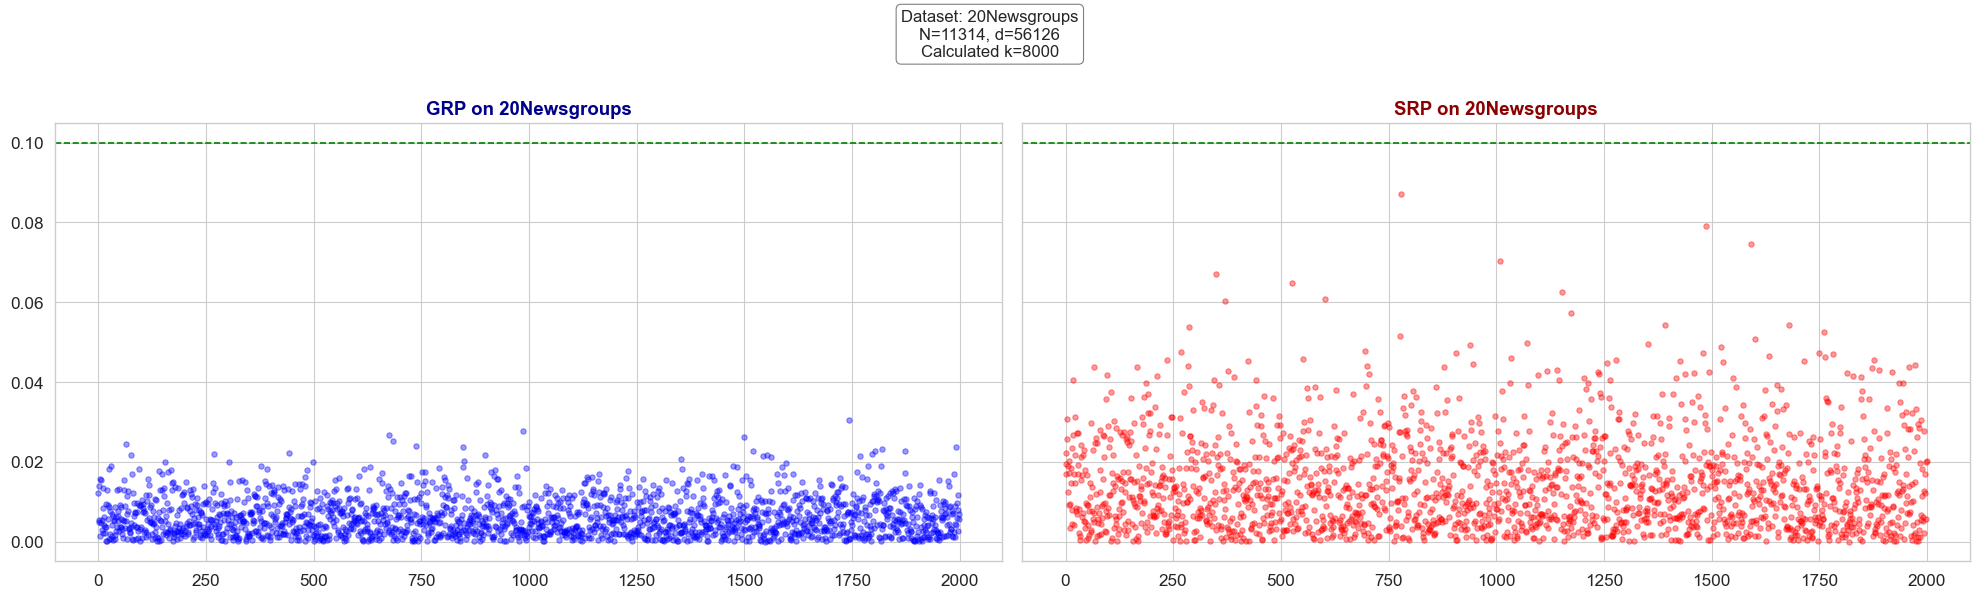

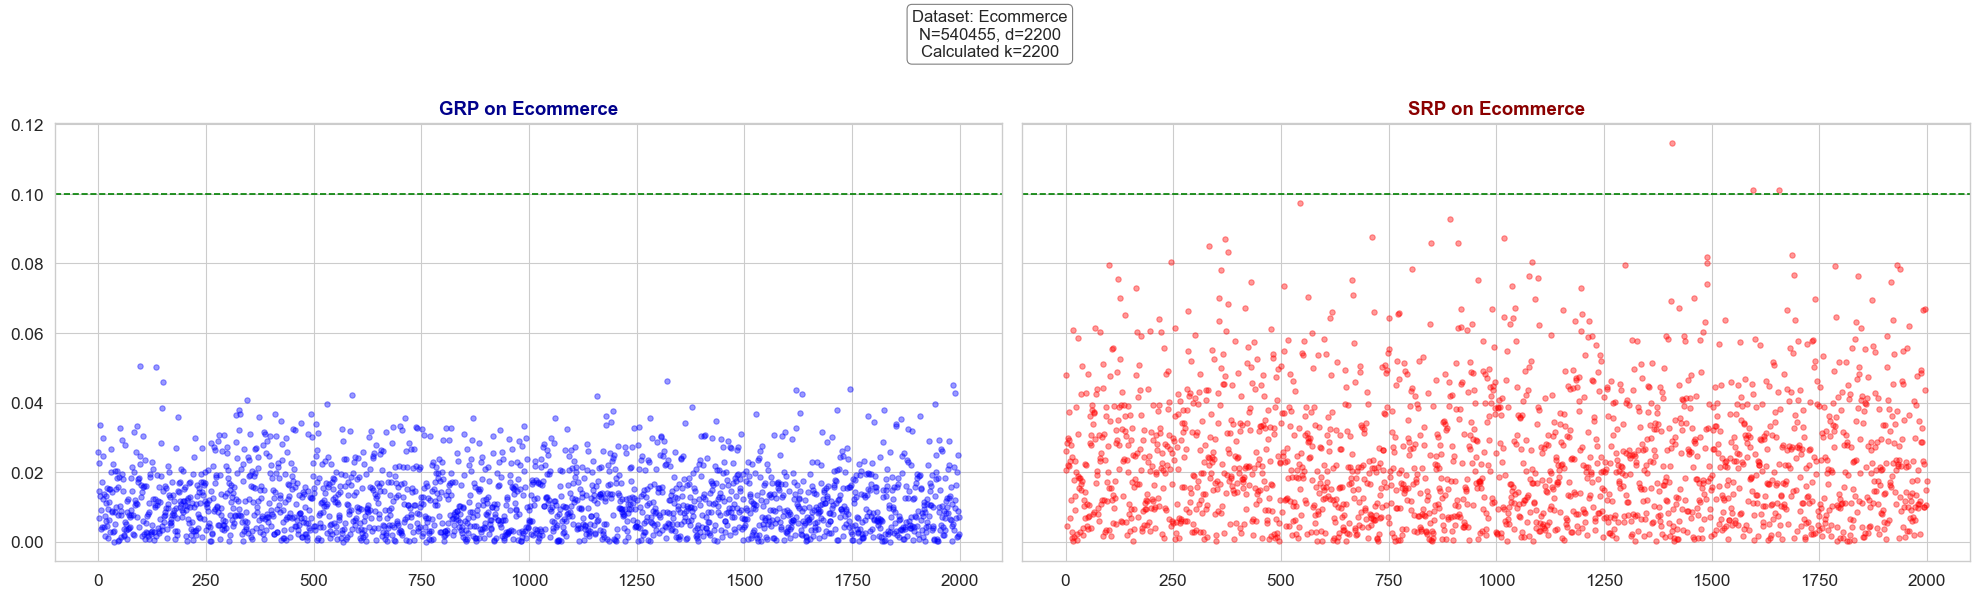

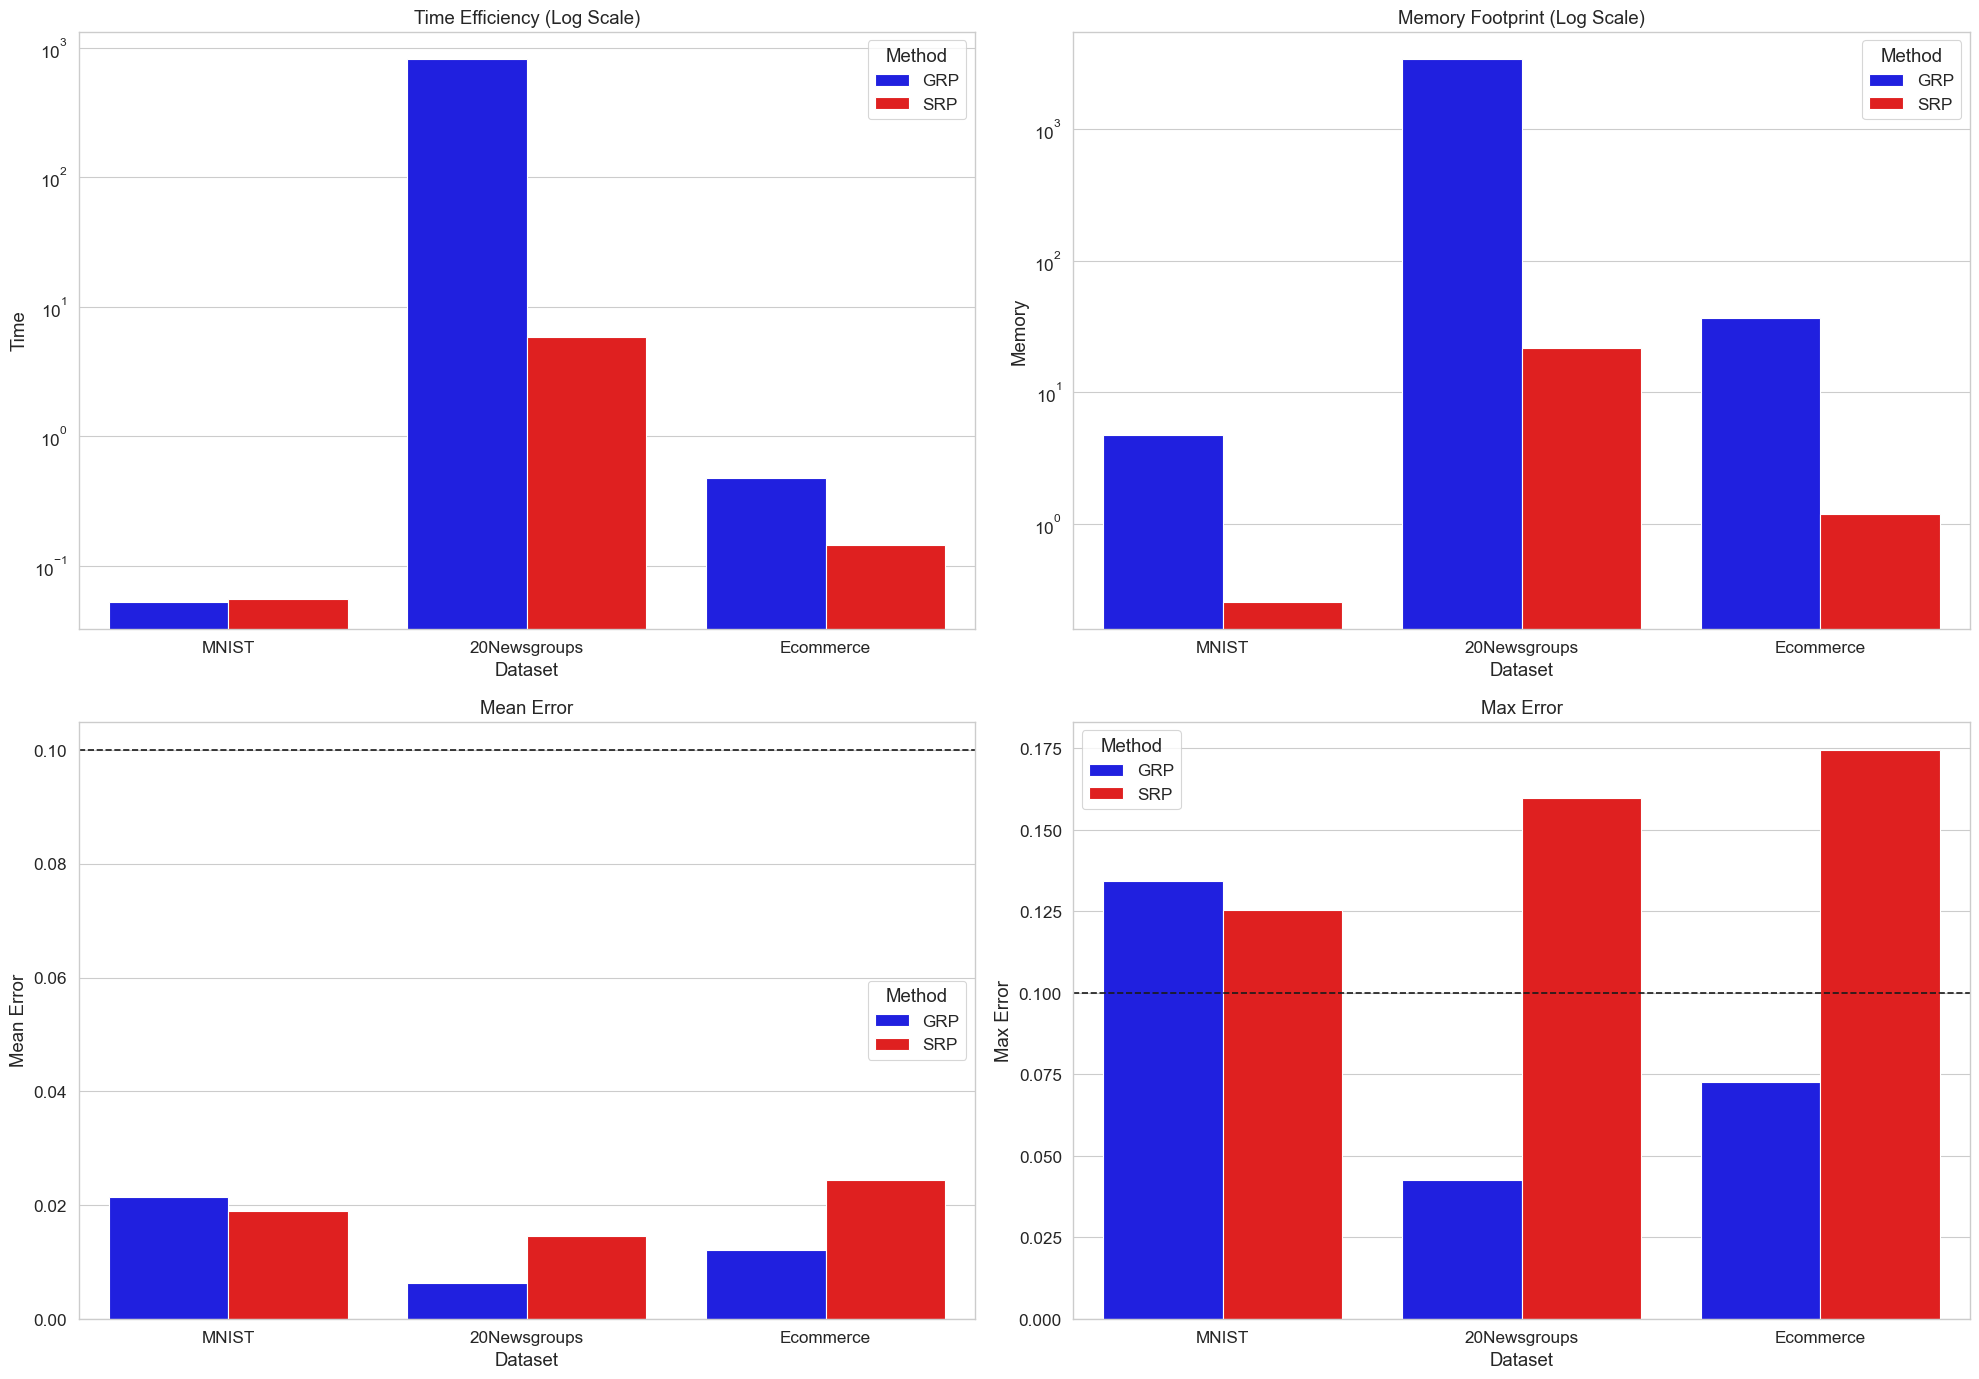


>>> ABLATION 1: Density vs Bennett Theory (Scientific Verification)
  Setup: N=2000, Fixed k=784, Target epsilon=0.1
    p=0.001: Fail Rate=0.0648, Theo m=3
    p=0.002: Fail Rate=0.0141, Theo m=5
    p=0.005: Fail Rate=0.0038, Theo m=17
    p=0.010: Fail Rate=0.0003, Theo m=46
    p=0.020: Fail Rate=0.0002, Theo m=129
    p=0.050: Fail Rate=0.0001, Theo m=570
    p=0.100: Fail Rate=0.0001, Theo m=1910
    p=0.300: Fail Rate=0.0000, Theo m=14685
    p=1.000: Fail Rate=0.0001, Theo m=152396


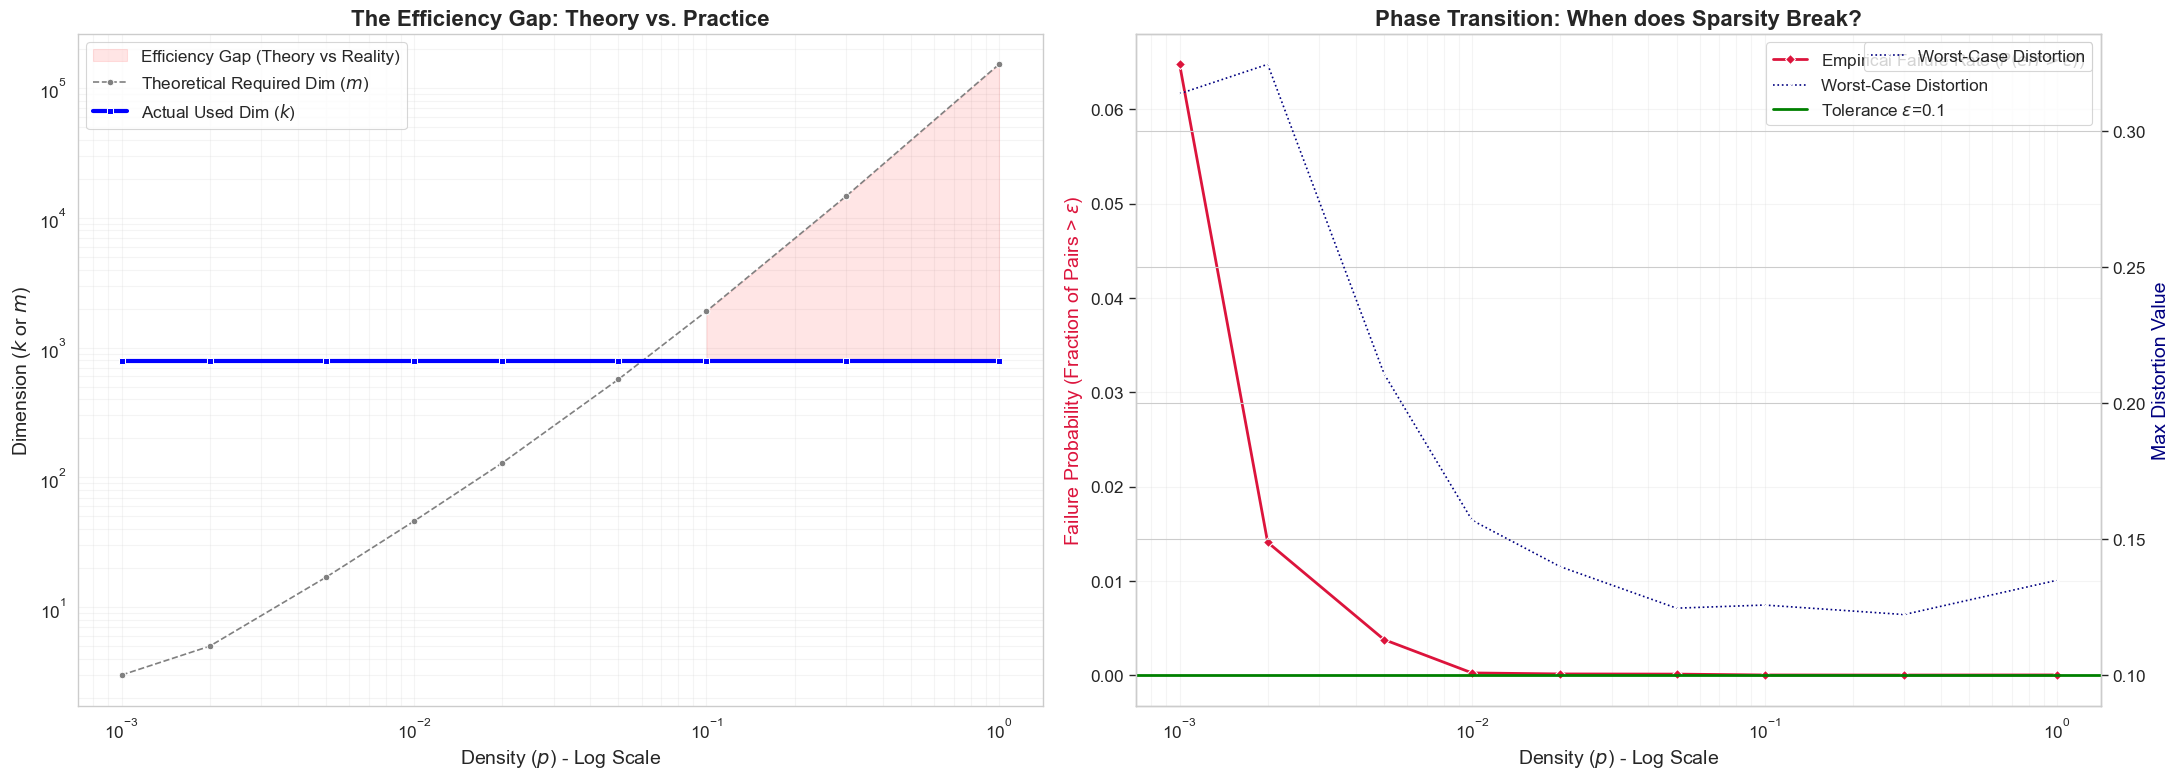


>>> ABLATION 2: Convergence Rate & Stability (Deep Analysis)
  Fixed Density for SRP: 0.0357 (Auto)


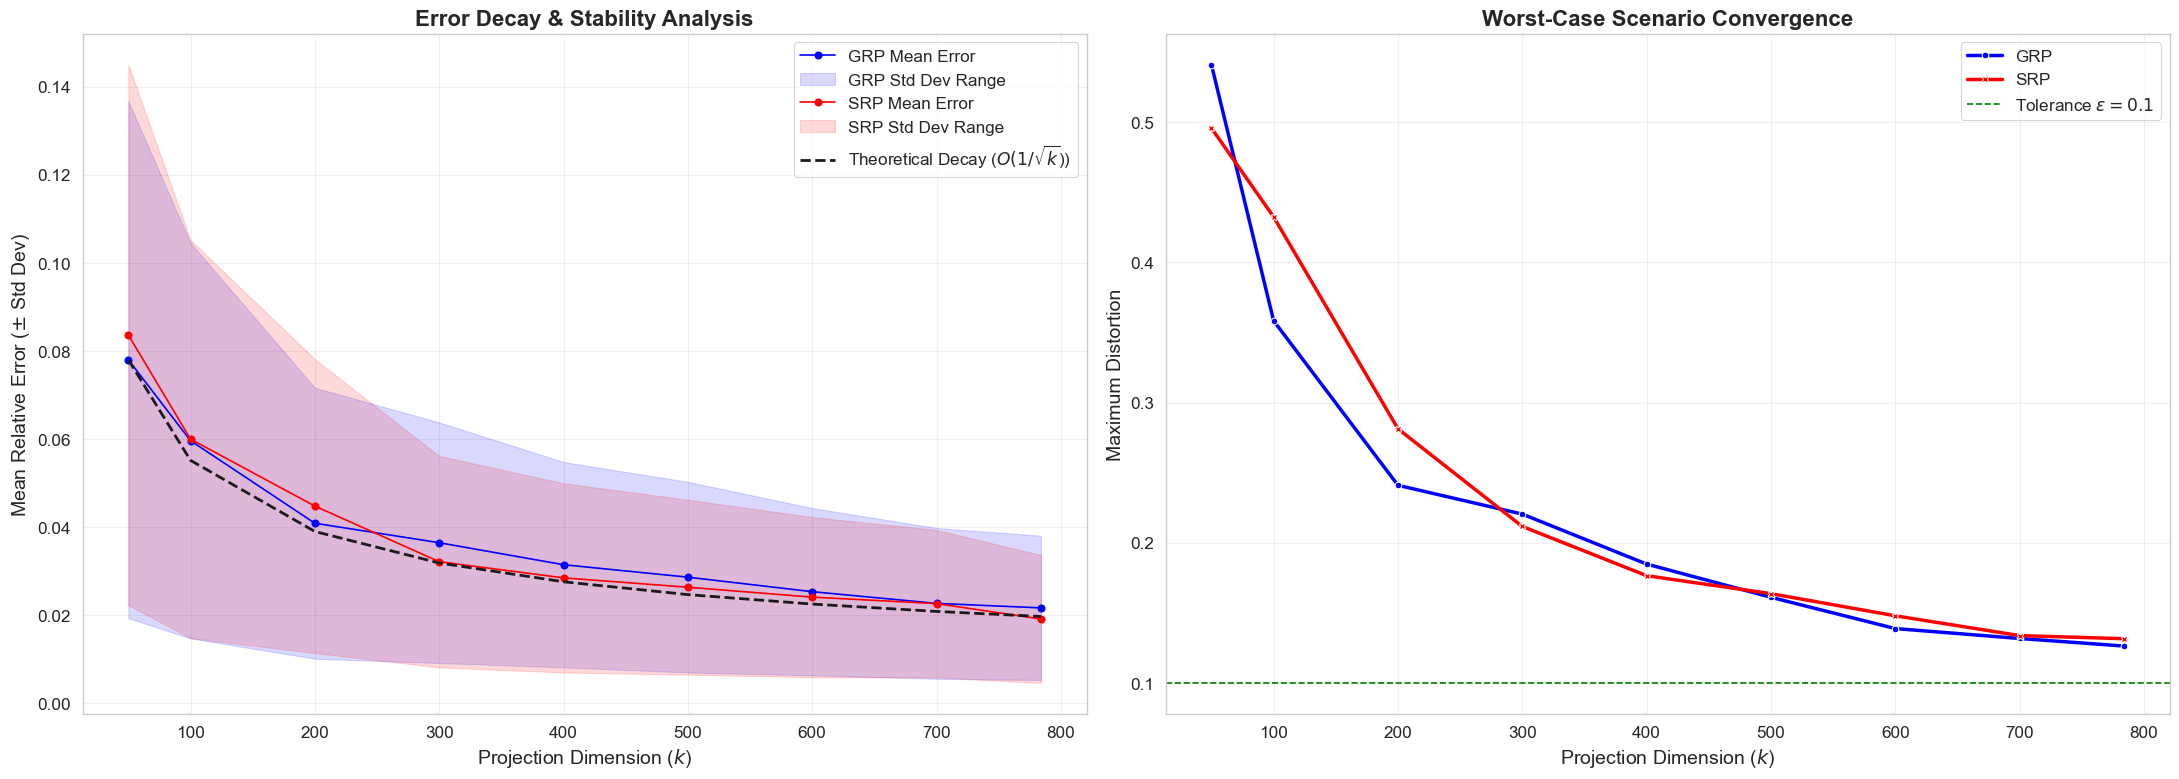


>>> ABLATION 3: Scalability & O(N) Verification (Advanced)
  Dataset: 20Newsgroups, Fixed k=300, Testing N from 1000 to 11314


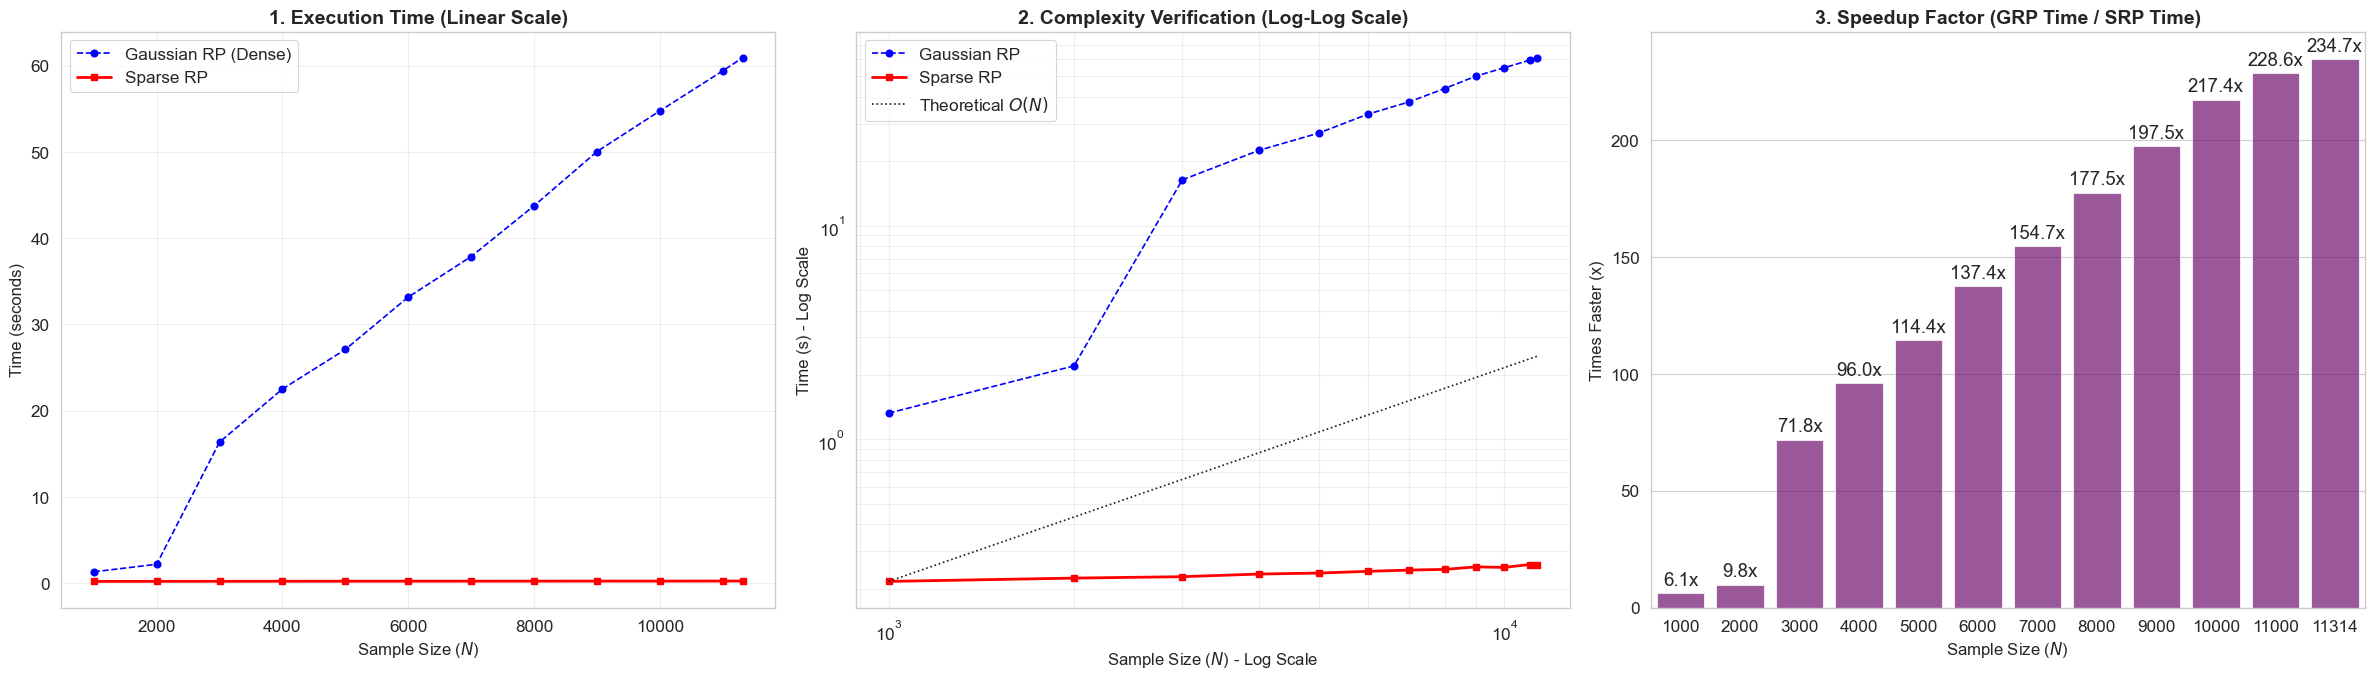


All experiments completed.


In [7]:
 if __name__ == "__main__":
    print("Loading Datasets...")
    datasets = []

    x1, y1, n1 = load_mnist()
    if x1 is not None: datasets.append((x1, y1, n1))

    x2, y2, n2 = load_20news()
    if x2 is not None: datasets.append((x2, y2, n2))

    x3, y3, n3 = load_ecommerce()
    if x3 is not None: datasets.append((x3, y3, n3))

    if not datasets:
        print("No datasets loaded. Check file paths in Config class.")
    else:
        # 2. Main Evaluation
        print("Running Main Evaluation...")
        df_results, scatter_data = run_evaluation_suite(datasets)
        plot_evaluation_scatter(scatter_data)
        plot_resource_metrics(df_results)
    
        # 3. Ablation Studies
    
        # Ablation 1: Density Improved (Boxplot & Accuracy)
        # Trả về 2 DF: 1 cho lỗi phân phối, 1 cho accuracy
        df_ab1 = run_ablation_density_professional(datasets) 
        plot_ablation_density_professional(df_ab1)
    
        # Ablation 2: Convergence
        df_conv = run_ablation_convergence_deep(datasets)
        plot_ablation_convergence_deep(df_conv)
    
        # Ablation 3: Scalability
        df_scale = run_ablation_scalability_advanced(datasets)
        plot_ablation_scalability_advanced(df_scale)

        print("\nAll experiments completed.")